# 🌊 Flood Area Segmentation with U-Net

This notebook demonstrates how to perform **image segmentation** for flood areas using the **U-Net architecture**.  

We will go through the following steps:
- Upload and extract dataset.
- Load images and masks.
- Visualize dataset samples.
- Split dataset into training and validation.
- Build a **U-Net model** from scratch.
- Train the model.
- Visualize predictions before and after training.
- Plot training performance (loss & accuracy curves).


In [1]:
# ======================================
# 1. Upload and extract the dataset
# ======================================

from google.colab import files
import zipfile, os

# Upload dataset (must be a .zip file)
uploaded = files.upload()

# Path to the uploaded zip
zip_path = "/content/floods dataset.zip"
extract_path = "/content/flood-area-segmentation"

# Extract zip file into target directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Display extracted folders
print("Extracted files:", os.listdir(extract_path))
print("Sample Images:", os.listdir(os.path.join(extract_path, "Image"))[:5])
print("Sample Masks:", os.listdir(os.path.join(extract_path, "Mask"))[:5])


Extracted files: ['metadata.csv', 'Mask', 'Image']
Sample Images: ['3065.jpg', '1084.jpg', '1054.jpg', '47.jpg', '3044.jpg']
Sample Masks: ['1034.png', '1048.png', '3072.png', '31.png', '3012.png']


## 2. Import Required Libraries
We will use:
- **NumPy** for array operations  
- **OpenCV (cv2)** for image processing  
- **Matplotlib** for visualization  
- **Scikit-learn** for train/validation/test split  
- **TensorFlow / Keras** for building the U-Net model


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

## 3. Load Images and Masks
This function will:
- Read each image and mask.  
- Resize them to `(256, 256)`.  
- Normalize pixel values to `[0, 1]`.  
- Expand mask dimensions to `(H, W, 1)` for compatibility with U-Net.

In [3]:
image_dir = "/content/flood-area-segmentation/Image/"
mask_dir  = "/content/flood-area-segmentation/Mask/"

IMG_HEIGHT, IMG_WIDTH = 256, 256

def load_images(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files  = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        # --- Load image ---
        img = cv2.imread(os.path.join(image_dir, img_file))
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        img = img / 255.0  # normalize to [0, 1]
        images.append(img)

        # --- Load mask ---
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)  # shape (H, W, 1)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

print("Loading dataset...")
X, Y = load_images(image_dir, mask_dir)
print("Dataset loaded:", X.shape, Y.shape)

Loading dataset...
Dataset loaded: (290, 256, 256, 3) (290, 256, 256, 1)


## 4. Visualize Dataset Samples
Let's display a few **images** with their corresponding **masks**.


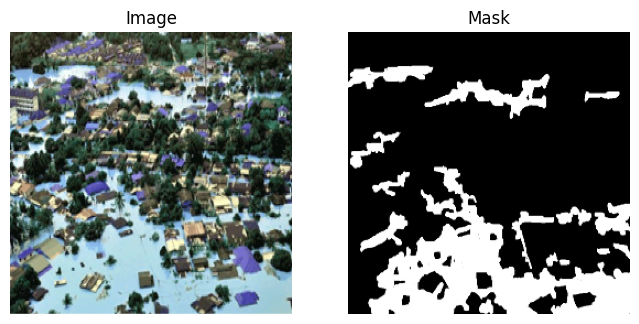

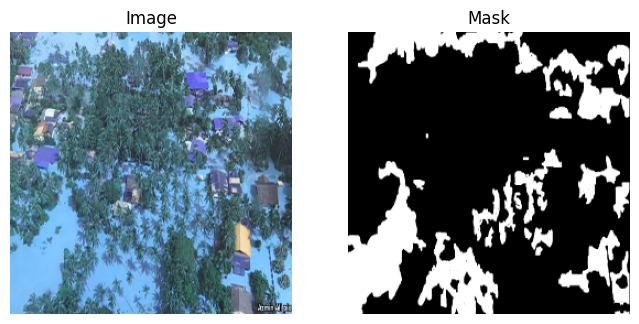

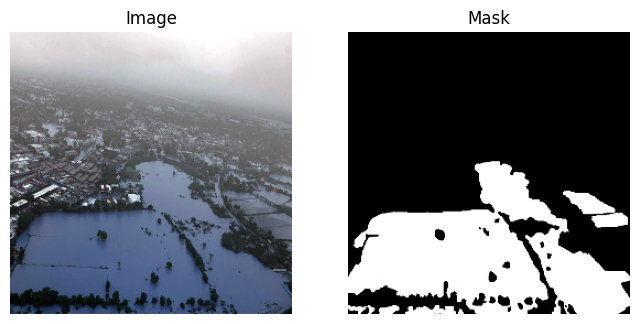

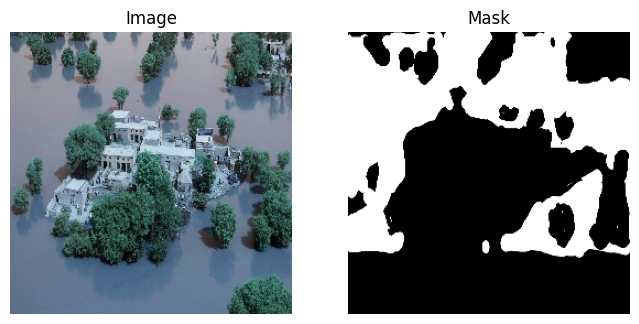

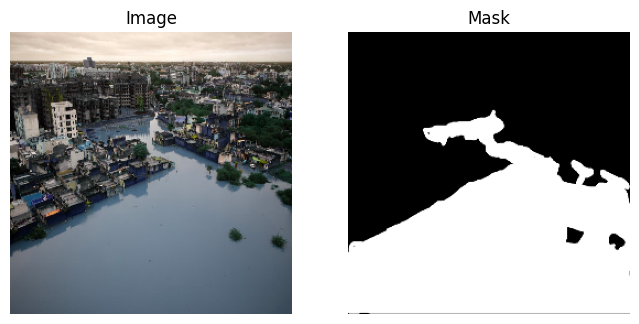

In [5]:
def show_samples(X, Y, num=5):
    for i in range(num):
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        plt.show()

show_samples(X, Y, num=5)

## 5. Split Dataset into Train / Validation / Test
We split the dataset into three sets:
- **Training set (70%)** → used to train the model  
- **Validation set (15%)** → used to tune hyperparameters and prevent overfitting  
- **Test set (15%)** → used to evaluate final model performance


In [6]:
# First split: Train (70%) + Temp (30%)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.30, random_state=42
)

# Second split: Validation (15%) + Test (15%)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.50, random_state=42
)

print("Training set:   ", X_train.shape, Y_train.shape)
print("Validation set: ", X_val.shape, Y_val.shape)
print("Test set:       ", X_test.shape, Y_test.shape)

Training set:    (203, 256, 256, 3) (203, 256, 256, 1)
Validation set:  (43, 256, 256, 3) (43, 256, 256, 1)
Test set:        (44, 256, 256, 3) (44, 256, 256, 1)


## 6. Build U-Net Model
We implement U-Net from scratch using Keras.  
The network consists of:
- **Encoder**: Down-sampling with convolution + max pooling  
- **Bottleneck**: Deep features  
- **Decoder**: Up-sampling with transpose convolutions + skip connections

In [7]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, activation="relu", padding="same")(p4)
    c5 = Conv2D(1024, 3, activation="relu", padding="same")(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation="relu", padding="same")(u6)
    c6 = Conv2D(512, 3, activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation="relu", padding="same")(u7)
    c7 = Conv2D(256, 3, activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation="relu", padding="same")(u8)
    c8 = Conv2D(128, 3, activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation="relu", padding="same")(u9)
    c9 = Conv2D(64, 3, activation="relu", padding="same")(c9)

    outputs = Conv2D(1, 1, activation="sigmoid")(c9)

    return Model(inputs=[inputs], outputs=[outputs])

# Build and compile model
model = unet_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # instead of 1e-3
model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train Model
We  train for 30 epochs to check functionality.



In [8]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=30
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6084 - loss: 0.6892 - val_accuracy: 0.5960 - val_loss: 0.6615
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.6779 - loss: 0.6096 - val_accuracy: 0.7647 - val_loss: 0.5113
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - accuracy: 0.7660 - loss: 0.4944 - val_accuracy: 0.8070 - val_loss: 0.4493
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 472ms/step - accuracy: 0.7495 - loss: 0.5160 - val_accuracy: 0.8083 - val_loss: 0.4422
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step - accuracy: 0.7911 - loss: 0.4583 - val_accuracy: 0.8080 - val_loss: 0.4205
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 496ms/step - accuracy: 0.7950 - loss: 0.4391 - val_accuracy: 0.8130 - val_loss: 0.3956
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.7812 - loss: 0.4622 - val_accuracy: 0.8021 - val_loss: 0.4319
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - accuracy: 0.7942 - loss: 0.4387 - val_accura

## 8. Visualization of Predictions
This function shows:
- Input Image  
- Ground Truth Mask  
- Predicted Mask

Predictions After training:
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


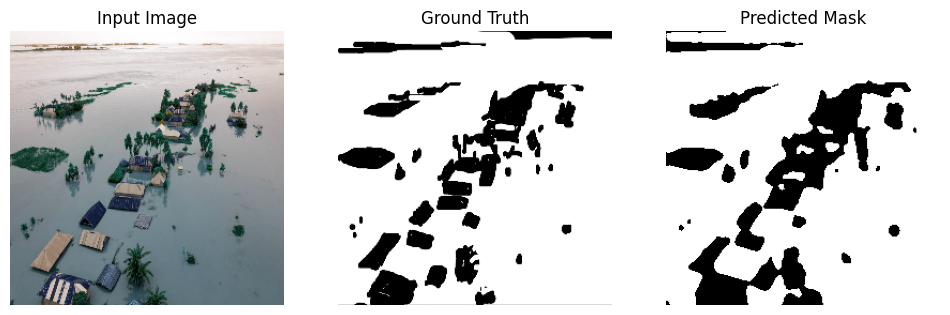

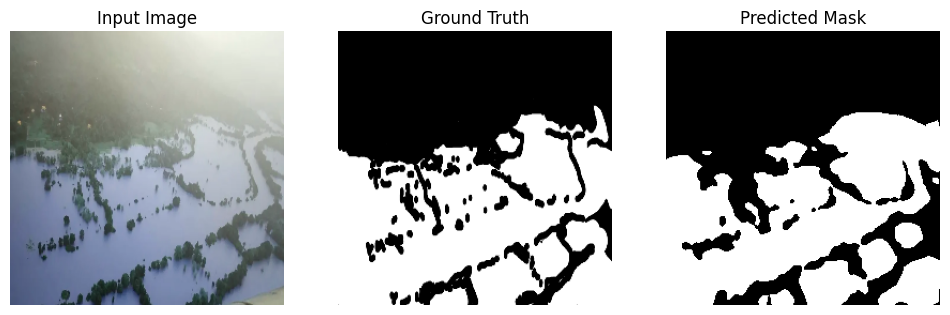

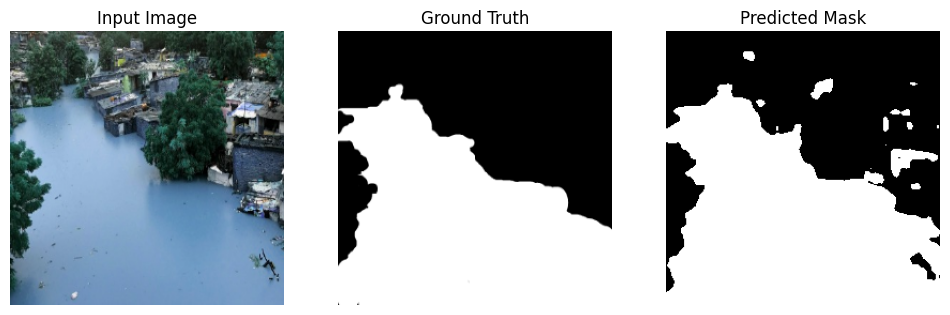

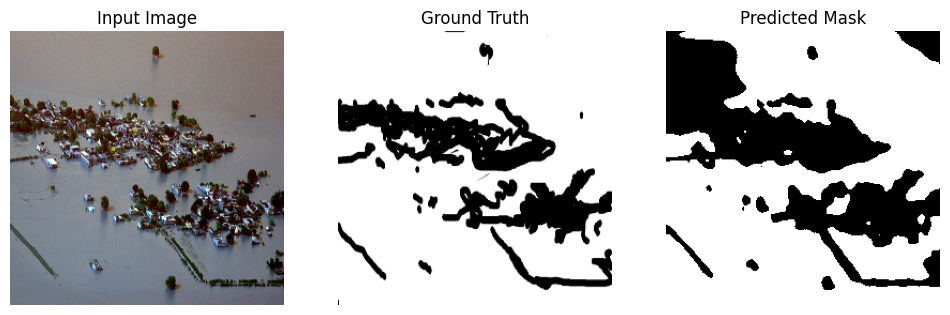

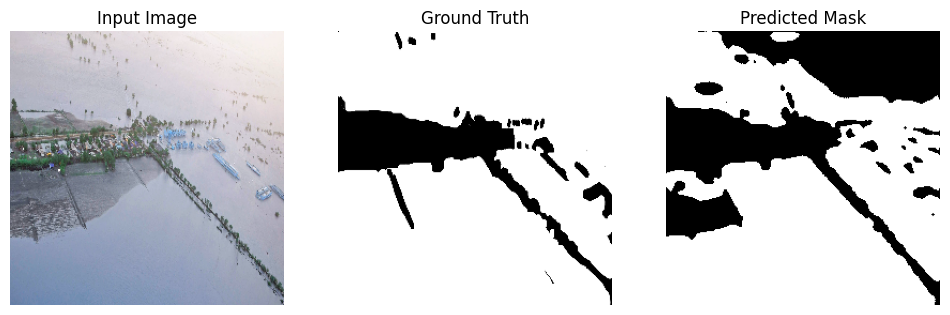

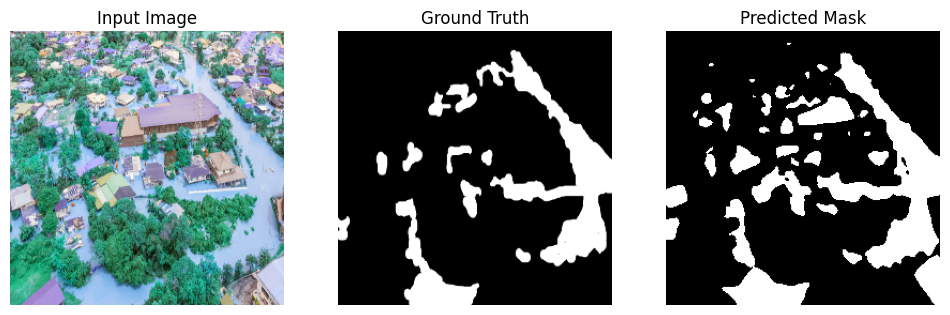

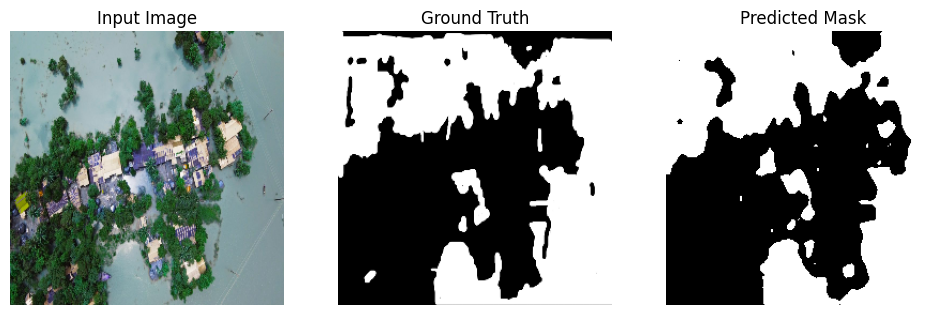

In [10]:
def visualize_predictions(model, X, Y, num=3, threshold=0.5):
    preds = model.predict(X[:num])
    for i in range(num):
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow((preds[i].squeeze() > threshold), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

print("Predictions After training:")
visualize_predictions(model, X_val, Y_val, num=7)

## 9. Plot Training Curves
We plot:
- **Loss** (training vs validation)
- **Accuracy** (training vs validation)

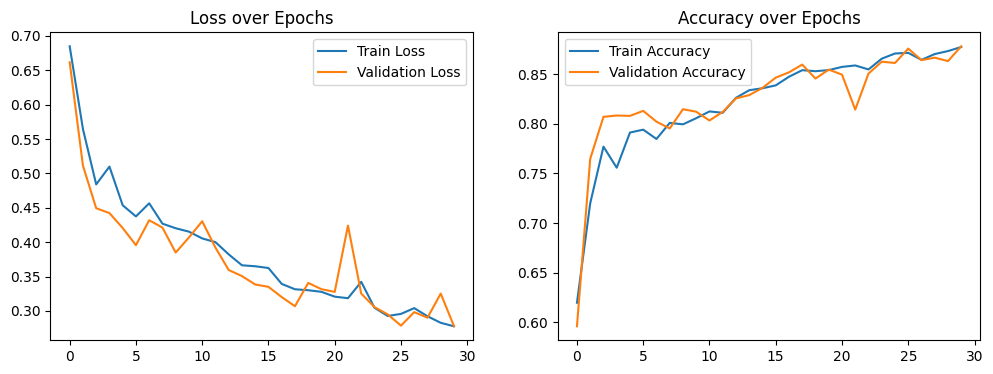

In [11]:
plt.figure(figsize=(12,4))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

## 10. Final Evaluation on Test Set
We evaluate the trained model on the unseen **test set** to measure generalization.

In [12]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.2549
Test Accuracy: 0.8841


Predictions After training:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


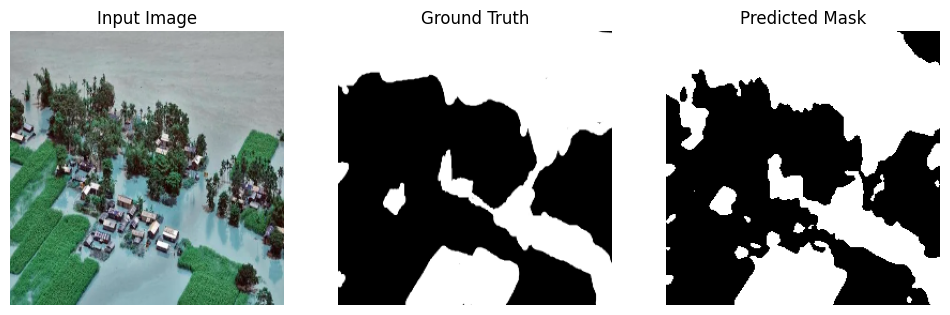

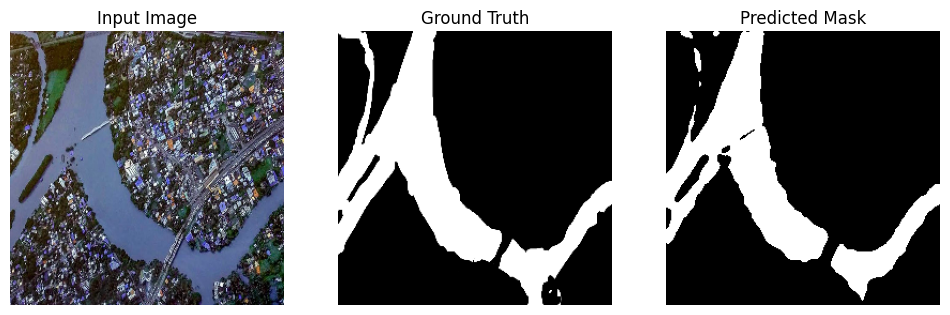

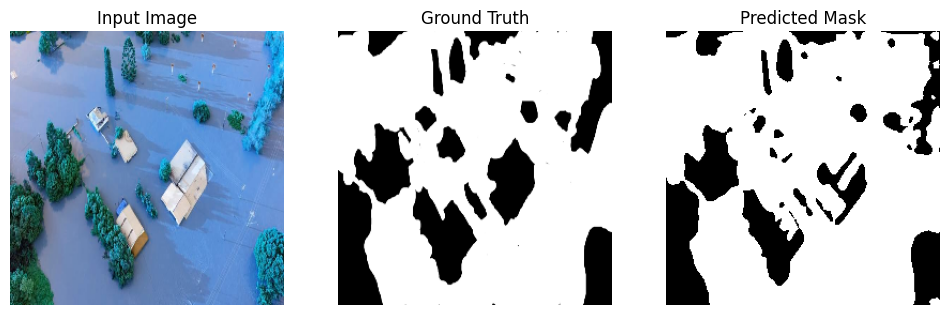

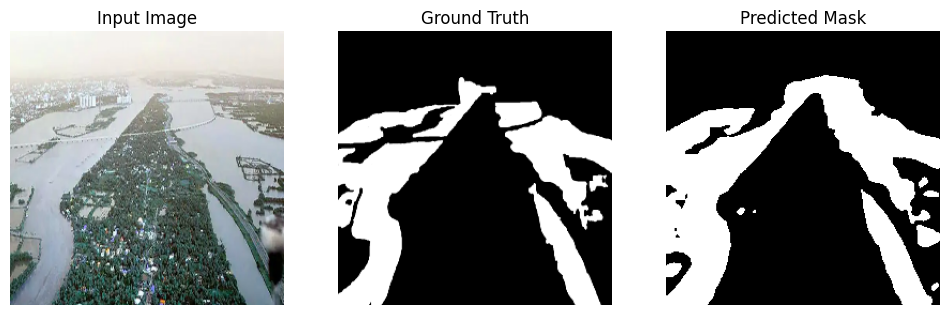

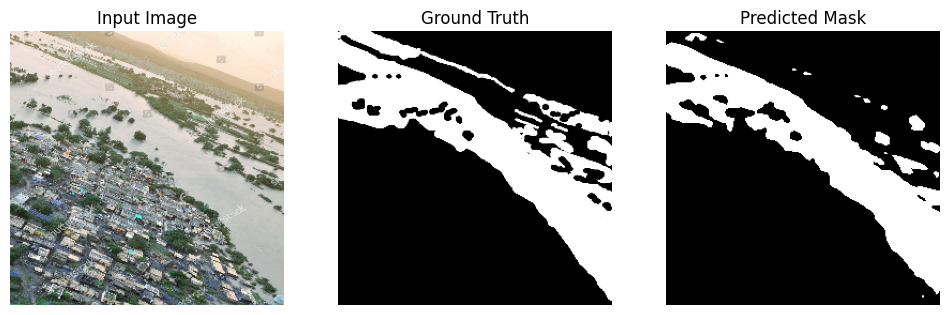

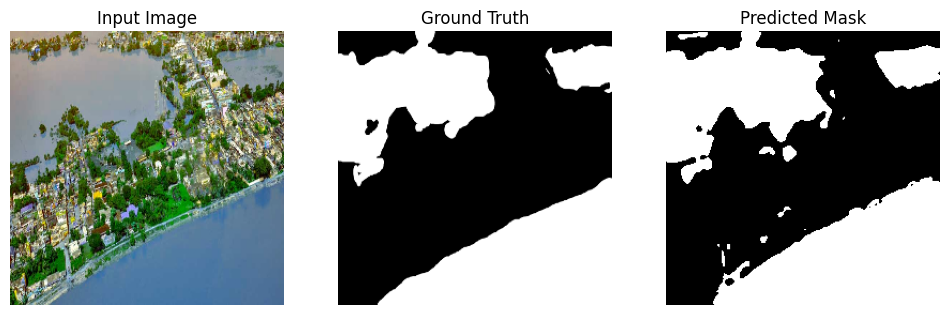

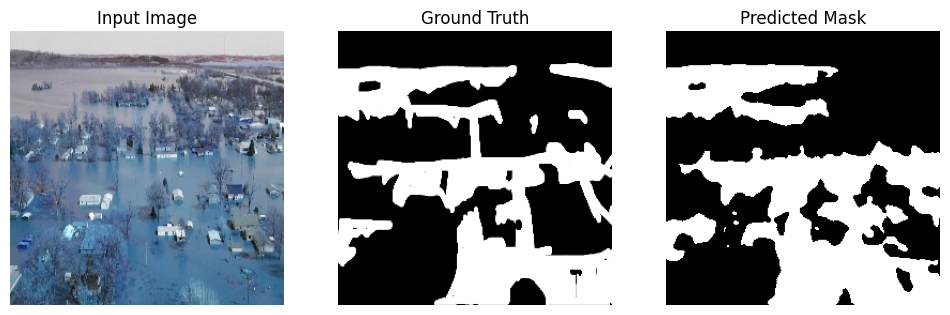

In [13]:
print("Predictions After training:")
visualize_predictions(model, X_test, Y_test, num=7)